In [1]:
## This file is part of Jax Geometry
#
# Copyright (C) 2021, Stefan Sommer (sommer@di.ku.dk)
# https://bitbucket.org/stefansommer/jaxgeometry
#
# Jax Geometry is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# Jax Geometry is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with Jax Geometry. If not, see <http://www.gnu.org/licenses/>.
#

# $\mathbb{S}^2$ Sphere Geometry

In [2]:
%load_ext autoreload
%autoreload 2

%cd ..

/home/fmry/PhD/Articles


In [3]:
from src.manifolds.S2 import *
M = S2()
print(M)
from src.plotting import *
from IPython.display import clear_output
#%matplotlib notebook

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


2d sphere (ellipsoid parameters [1. 1. 1.], spherical_coords: False)


In [4]:
# element, tangent vector and covector
x = M.coords([0.,0.])

## Riemannian structure
from src.Riemannian import metric
metric.initialize(M)

## Brownian Motion

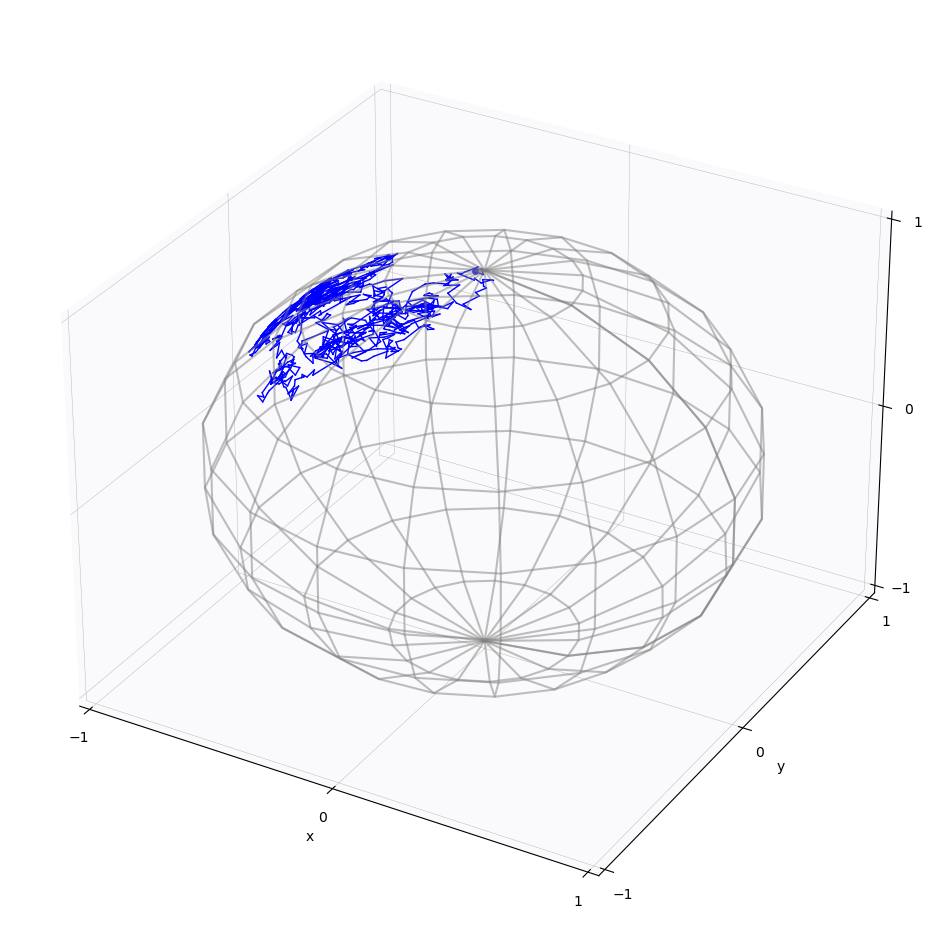

In [5]:
# coordinate form
from src.stochastics import Brownian_coords
Brownian_coords.initialize(M)

_dts = dts(n_steps=1000)
(ts,xs,charts) = M.Brownian_coords(x,_dts,dWs(M.dim,_dts))

# plot
newfig()
M.plot()
M.plot_path(zip(xs,charts))
plt.show()

In [6]:
# product sde
from src.stochastics import product_sde
from src.stochastics.product_sde import tile
(product,sde_product,chart_update_product) = product_sde.initialize(M,M.sde_Brownian_coords,M.chart_update_Brownian_coords)

In [7]:
def get_coords(Fx):
    chart = M.centered_chart(Fx)
    return (M.invF((Fx,chart)),chart)

def to_TM(Fx,v):
    x = get_coords(Fx)
#     return jnp.dot(M.JF(x),jnp.dot(M.invJF((Fx,x[1])),v))
    JFx = M.JF(x)
    return jnp.dot(JFx,jnp.linalg.lstsq(JFx,v)[0])

# Score matching, fixed $x_0,t$

In [8]:
import haiku as hk
import optax
import jaxopt
import tensorflow as tf
import tensorflow_datasets as tfds

learning_rate = 0.01 # Learning rate for optimizer
epochs = 20 # Number of passes over the dataset
batch_size = 2**5
samples_size = batch_size*2**4 # Total number of samples per epoch
print(batch_size,samples_size)

def generator():
    while True:
        """Generates batches of samples."""
        N = batch_size
        _dts = dts(T=.5)
        (ts,xss,chartss,*_) = product(tile(x,N),_dts,dWs(N*M.dim,_dts).reshape(-1,N,M.dim),jnp.repeat(1.,N))
        samples = xss[-1]
        charts = chartss[-1] 
#         yield jnp.hstack((samples,charts))
        yield jax.vmap(lambda x,chart: M.F((x,chart)))(samples,charts)
        
ds = tf.data.Dataset.from_generator(generator,output_types=tf.float32,output_shapes=([batch_size,M.emb_dim]))

print(ds)
print(ds.element_spec)
ds = iter(tfds.as_numpy(ds))

def net_f(x):
    """Create model."""
    model = hk.Sequential([
        hk.Linear(20), jax.nn.tanh,
        hk.Linear(10), jax.nn.tanh,
        hk.Linear(M.emb_dim),
    ])
#     y = jax.vmap(to_TM)(x.reshape([-1,M.emb_dim]),model(x.reshape([-1,M.emb_dim]))).reshape(x.shape)
    y = model(x)
    return y


maxiter = epochs * samples_size // batch_size

# initialize net and parameters
net = hk.without_apply_rng(hk.transform(net_f))
params = net.init(jax.random.PRNGKey(42), next(ds))

def loss_fun(params, data):
    """ compute loss."""
    s = net.apply(params, data)
    (xs,charts) = jax.vmap(get_coords)(data)
    norm2s = jax.vmap(lambda s: jnp.sum(jnp.square(s)))(s)
    divs = jax.vmap(lambda x,chart,s: M.div((x,chart),
                                            lambda x: jnp.dot(M.invJF((M.F(x),x[1])),
                                                                net.apply(params,M.F(x))))
                   )(xs,charts,s)
#     # plot
#     newfig()
#     M.plot()
#     for i in range(xs.shape[0]):
#         M.plotx((xs[i],charts[i]))
#     plt.show()
    return jnp.mean(norm2s+divs)

# Initialize solver.
def pre_update(params,state,*ars,**kwargs):
    if state.iter_num % 10 == 0:
        print(f"[Step {state.iter_num}], epoch {state.iter_num//(samples_size//batch_size)}, training loss: {state.value:.3f}.")
    return params,state

opt = optax.sgd(learning_rate)
solver = jaxopt.OptaxSolver(opt=opt,fun=loss_fun,maxiter=maxiter,pre_update=pre_update)

# run training loop
state = solver.init_state(params)
params, state = solver.run_iterator(
    init_params=params, iterator=ds)


2023-03-29 16:15:04.429143: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-29 16:15:04.857469: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-29 16:15:04.857524: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-29 16:15:04.857528: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed proper

32 512
<FlatMapDataset element_spec=TensorSpec(shape=(32, 3), dtype=tf.float32, name=None)>
TensorSpec(shape=(32, 3), dtype=tf.float32, name=None)


2023-03-29 16:15:05.690659: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-29 16:15:05.690727: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-03-29 16:15:05.690768: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-03-29 16:15:05.690797: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2023-03-29 16:15:05.690832: W tensorfl

[Step 0], epoch 0, training loss: inf.
[Step 10], epoch 0, training loss: 0.014.
[Step 20], epoch 1, training loss: -0.231.
[Step 30], epoch 1, training loss: -0.418.
[Step 40], epoch 2, training loss: -0.197.
[Step 50], epoch 3, training loss: -0.537.
[Step 60], epoch 3, training loss: -0.671.
[Step 70], epoch 4, training loss: -0.839.
[Step 80], epoch 5, training loss: -0.829.
[Step 90], epoch 5, training loss: -0.691.
[Step 100], epoch 6, training loss: -0.645.
[Step 110], epoch 6, training loss: -0.898.
[Step 120], epoch 7, training loss: -0.897.
[Step 130], epoch 8, training loss: -0.523.
[Step 140], epoch 8, training loss: -0.866.
[Step 150], epoch 9, training loss: -0.817.
[Step 160], epoch 10, training loss: -0.852.
[Step 170], epoch 10, training loss: -0.837.
[Step 180], epoch 11, training loss: -0.644.
[Step 190], epoch 11, training loss: -0.502.
[Step 200], epoch 12, training loss: -0.662.
[Step 210], epoch 13, training loss: -1.234.
[Step 220], epoch 13, training loss: -1.0

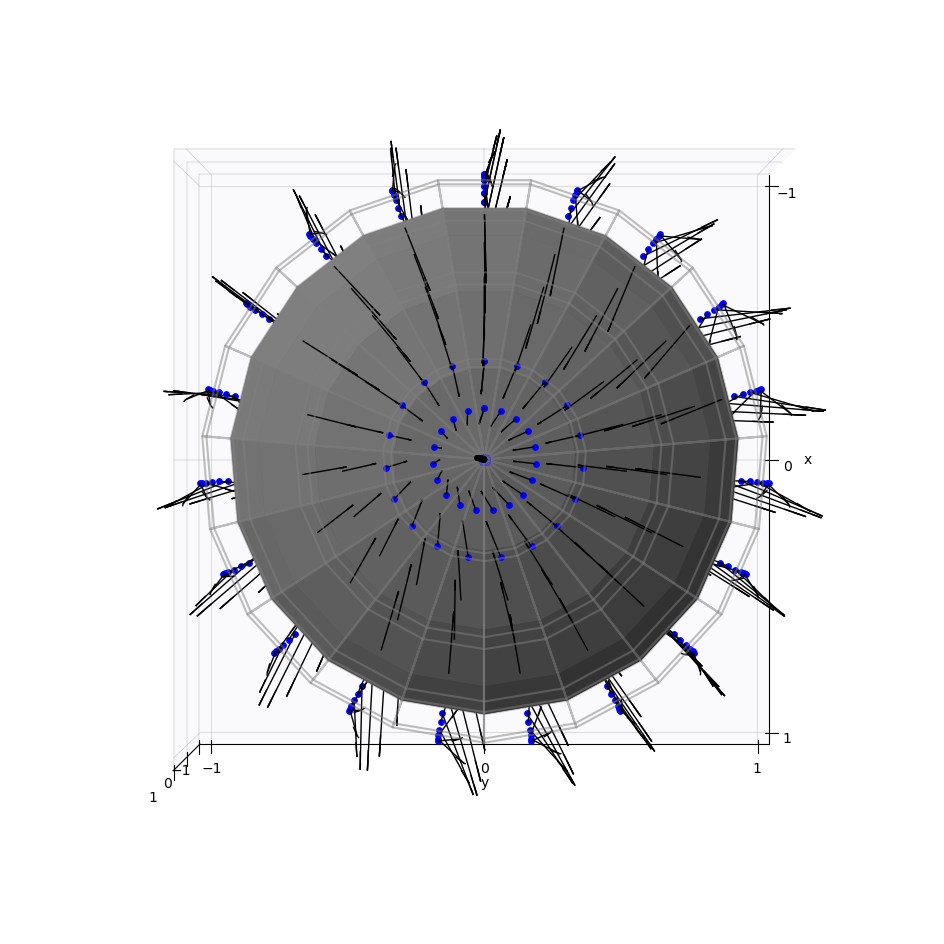

In [9]:
%matplotlib inline
newfig()
M.plot(alpha=1.,scale=.9,rotate=(90,0))
plot_sphere_f(M,lambda Fx: to_TM(Fx,net.apply(params,Fx)),pts=20)

# Score matching, fixed $x_0$

In [11]:
import haiku as hk
import optax
import jaxopt
import tensorflow as tf
import tensorflow_datasets as tfds

learning_rate = 0.01 # Learning rate for optimizer
epochs = 50 # Number of passes over the dataset
ts_per_batch = 2**4
repeats = 2**5
batch_size = ts_per_batch*repeats
samples_size = batch_size*2**4 # Total number of samples per epoch
print(ts_per_batch,repeats,batch_size,samples_size)

x0s = tile(x,repeats)

def generator():
    while True:
        """Generates batches of samples."""
        N = repeats
        _dts = dts(T=1.)
        global x0s
        (ts,xss,chartss,*_) = product(x0s,_dts,dWs(N*M.dim,_dts).reshape(-1,N,M.dim),jnp.repeat(1.,N))        
        inds = np.random.choice(range(_dts.shape[0]),ts_per_batch,replace=False)
#         inds = jnp.arange(0,ts.shape[0]+1,ts.shape[0]//ts_per_batch)[1:]-1
#         inds = jnp.array([49,99])
        ts = ts[inds]
        samples = xss[inds]
        charts = chartss[inds]
        yield jnp.hstack((jax.vmap(lambda x,chart: M.F((x,chart)))(samples.reshape((-1,M.dim)),charts.reshape((-1,chartss.shape[-1]))),
                         jnp.repeat(ts.reshape((-1,1)),N,axis=1).reshape((-1,1))
                        ))
        
ds = tf.data.Dataset.from_generator(generator,output_types=tf.float32,output_shapes=([batch_size,M.emb_dim+1]))

print(ds)
print(ds.element_spec)
ds = iter(tfds.as_numpy(ds))

def net_f(x):
    """Create model."""
    model = hk.Sequential([
        hk.Linear(30), jax.nn.tanh,
        hk.Linear(20), jax.nn.tanh,
        hk.Linear(M.emb_dim),
    ])
    y = model(x)
    return y


maxiter = epochs * samples_size // batch_size

# initialize net and parameters
net = hk.without_apply_rng(hk.transform(net_f))
params = net.init(jax.random.PRNGKey(42), next(ds))

def loss_fun(params, data):
    """ compute loss."""
    s = net.apply(params,data)
    Fxts = data[:,0:M.emb_dim]
    ts = data[:,-1]
    (xts,chartts) = jax.vmap(get_coords)(Fxts)
    norm2s = jax.vmap(lambda s: jnp.sum(jnp.square(s)))(s)
    divs = jax.vmap(lambda xt,chartt,t: M.div((xt,chartt),
                                              lambda x: jnp.dot(M.invJF((M.F(x),x[1])),
                                                                net.apply(params,jnp.hstack((M.F(x),t)))))
                   )(xts,chartts,ts)
    return jnp.mean(norm2s+divs)

# Initialize solver.
losses = []
def pre_update(params,state,*ars,**kwargs):
    losses.append(state.value)
    if state.iter_num % 10 == 0:
        print(f"[Step {state.iter_num}], epoch {state.iter_num//(samples_size//batch_size)}, training loss: {state.value:.3f}.")
    return params,state

opt = optax.sgd(learning_rate)
solver = jaxopt.OptaxSolver(opt=opt,fun=loss_fun,maxiter=maxiter,pre_update=pre_update)

# run training loop
state = solver.init_state(params)
params, state = solver.run_iterator(
    init_params=params, iterator=ds)

# print loss graph
plt.plot(jnp.arange(0,len(losses)),jnp.array(losses))

16 32 512 8192
(32, 2)


NameError: name 'N' is not defined

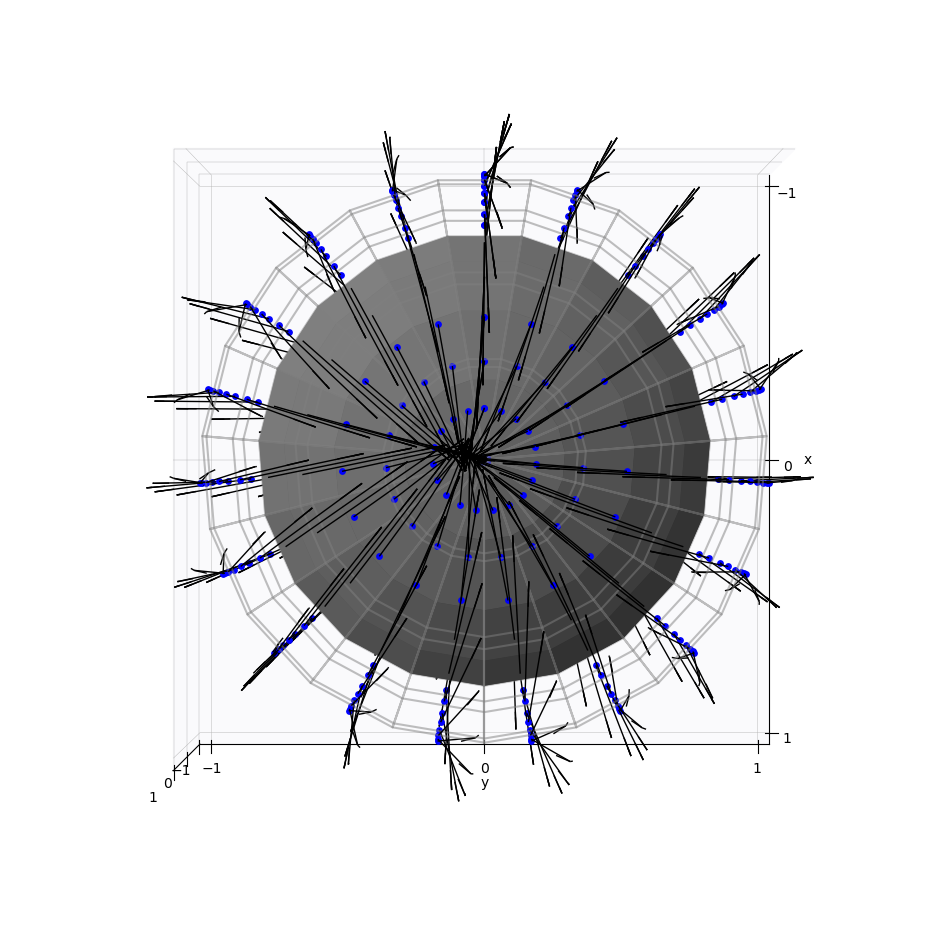

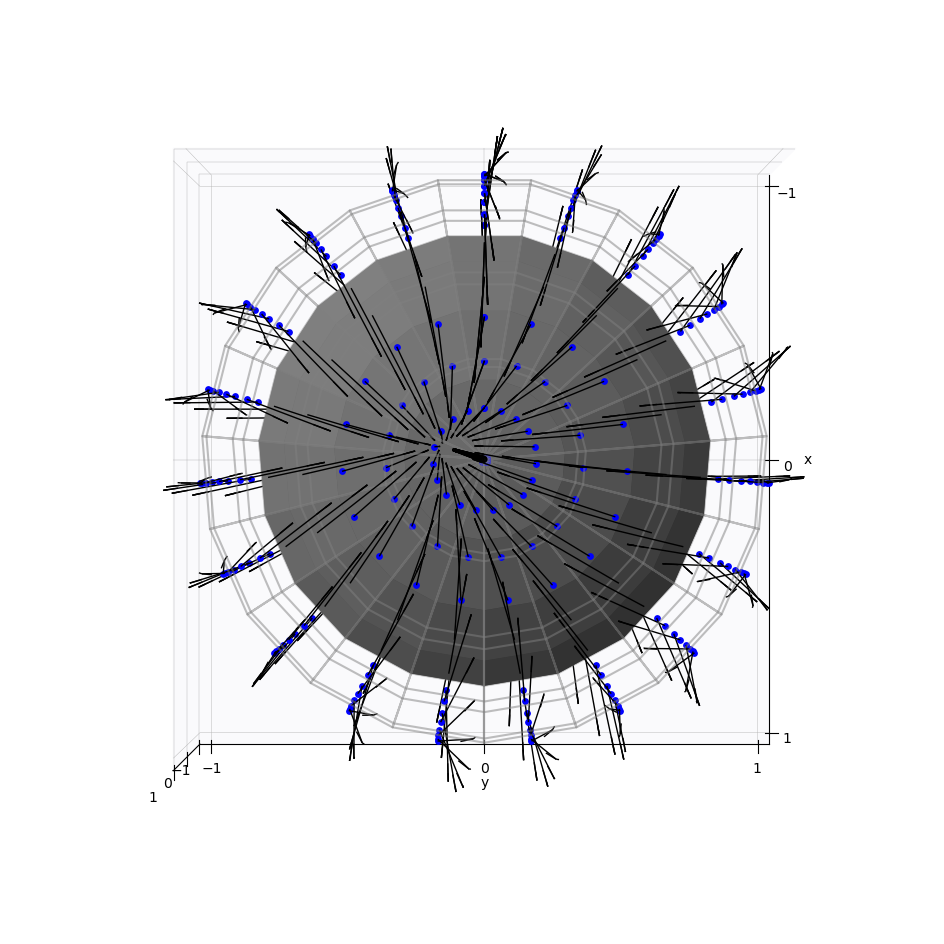

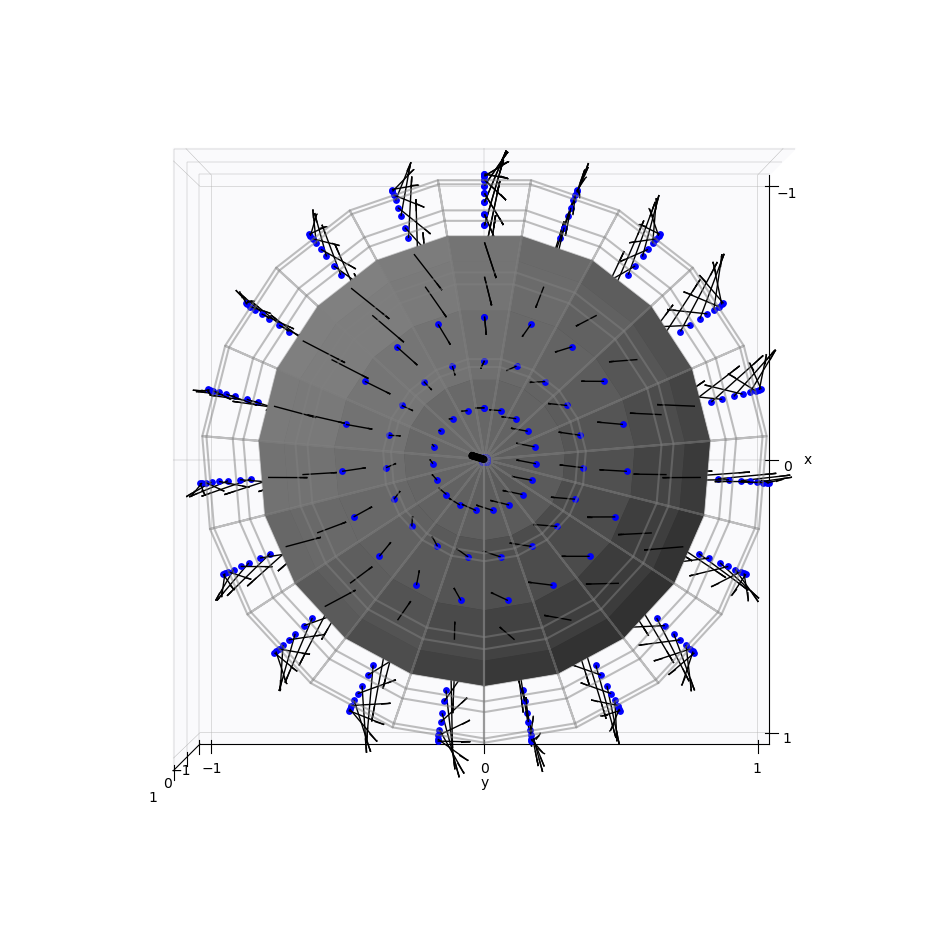

In [22]:
newfig()
M.plot(alpha=1.,scale=.8,rotate=(90,0))
plot_sphere_f(M,lambda Fx: to_TM(Fx,net.apply(params,jnp.hstack((Fx,.25)))),pts=20)

newfig()
M.plot(alpha=1.,scale=.8,rotate=(90,0))
plot_sphere_f(M,lambda Fx: to_TM(Fx,net.apply(params,jnp.hstack((Fx,.5)))),pts=20)

newfig()
M.plot(alpha=1.,scale=.8,rotate=(90,0))
plot_sphere_f(M,lambda Fx: to_TM(Fx,net.apply(params,jnp.hstack((Fx,1.)))),pts=20)

# Score matching, fixed $t$

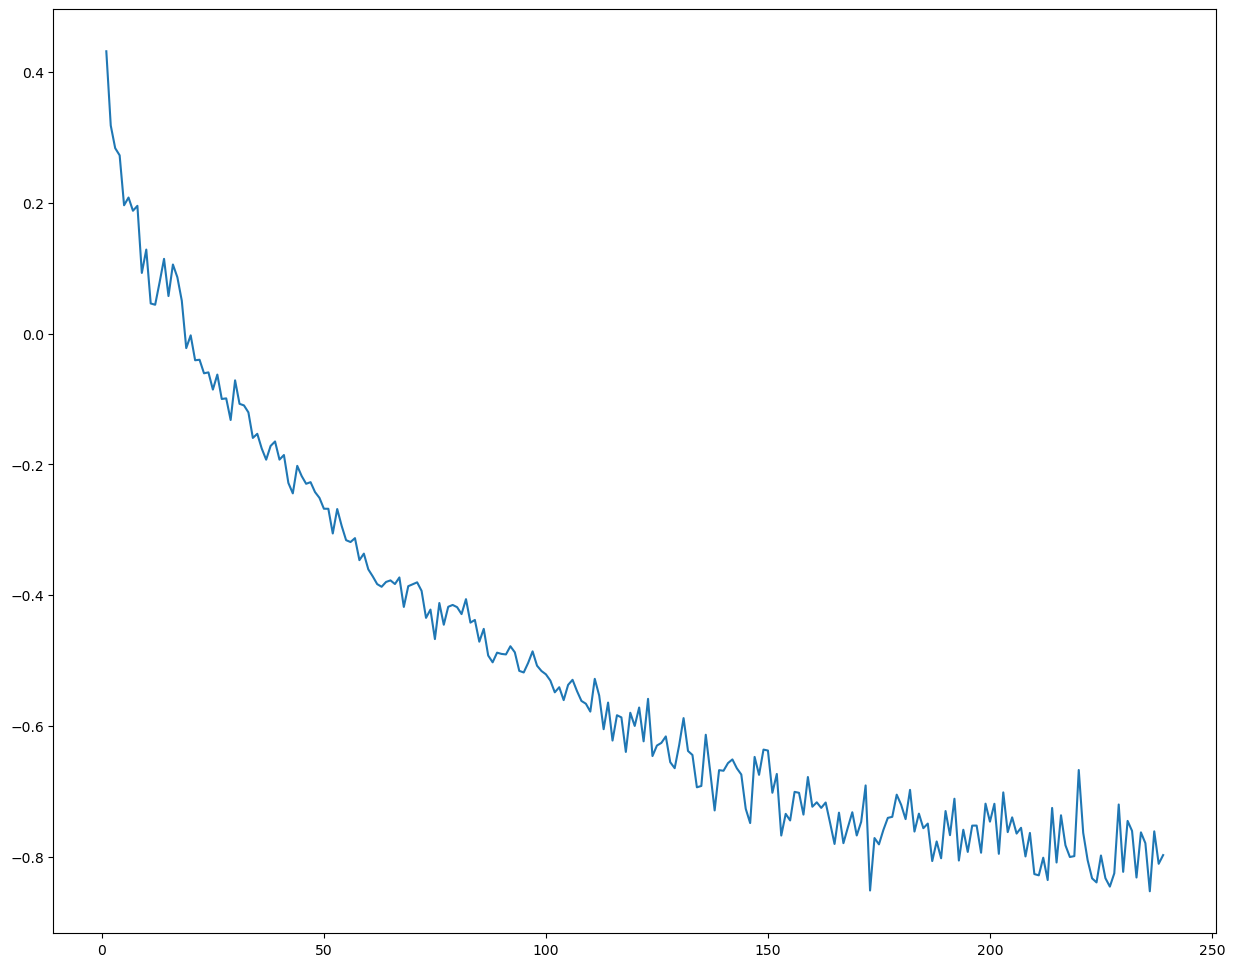

In [23]:
import haiku as hk
import optax
import jaxopt
import tensorflow as tf
import tensorflow_datasets as tfds

learning_rate = 0.01 # Learning rate for optimizer
epochs = 15 # Number of passes over the dataset
samples_per_x0 = 2**5
batch_size = samples_per_x0*2**3
samples_size = batch_size*2**4 # Total number of samples per epoch
print(samples_per_x0,batch_size,samples_size)

global x0s
x0s = tile(x,batch_size)

def generator():
    while True:
        """Generates batches of samples."""
        N = batch_size
        _dts = dts(T=.5)
        global x0s
        (ts,xss,chartss,*_) = product(x0s,_dts,dWs(N*M.dim,_dts).reshape(-1,N,M.dim),jnp.repeat(1.,N))
        samples = xss[-1]
        charts = chartss[-1]
        Fx0s = jax.vmap(lambda x,chart: M.F((x,chart)))(*x0s)
        x0s = (jnp.repeat(samples[::samples_per_x0],samples_per_x0,axis=0),
               jnp.repeat(charts[::samples_per_x0],samples_per_x0,axis=0))
        yield jnp.hstack((Fx0s,
                          jax.vmap(lambda x,chart: M.F((x,chart)))(samples,charts)))
        
ds = tf.data.Dataset.from_generator(generator,output_types=tf.float32,output_shapes=([batch_size,2*M.emb_dim]))

print(ds)
print(ds.element_spec)
ds = iter(tfds.as_numpy(ds))

def net_f(x):
    """Create model."""
    model = hk.Sequential([
        hk.Linear(30), jax.nn.tanh,
        hk.Linear(20), jax.nn.tanh,
        hk.Linear(M.emb_dim),
    ])
#     y = jnp.squeeze(jax.vmap(to_TM)(x.reshape([-1,2*M.emb_dim])[:,M.emb_dim:],model(x.reshape([-1,2*M.emb_dim]))))
    y = model(x)
    return y


maxiter = epochs * samples_size // batch_size

# initialize net and parameters
net = hk.without_apply_rng(hk.transform(net_f))
params = net.init(jax.random.PRNGKey(42), next(ds))

def loss_fun(params, data):
    """ compute loss."""
    s = net.apply(params,data)
    Fx0s = data[:,0:M.emb_dim]
    Fxts = data[:,M.emb_dim:]
    (xts,chartts) = jax.vmap(get_coords)(Fxts)
    norm2s = jax.vmap(lambda s: jnp.sum(jnp.square(s)))(s)
    divs = jax.vmap(lambda Fx0,xt,chartt: M.div((xt,chartt),
                                                lambda x: jnp.dot(M.invJF((M.F(x),x[1])),
                                                                  net.apply(params,jnp.hstack((Fx0,M.F(x))))))
                   )(Fx0s,xts,chartts)
    return jnp.mean(norm2s+divs)

# Initialize solver.
losses = []
def pre_update(params,state,*ars,**kwargs):
    losses.append(state.value)
    if state.iter_num % 10 == 0:
#         print(f"[Step {state.iter_num}], epoch {state.iter_num//(samples_size//batch_size)}, training loss: {state.value:.3f}.")
        clear_output(wait=True); plt.plot(jnp.arange(0,len(losses)),jnp.array(losses)); plt.show()
    return params,state

opt = optax.sgd(learning_rate)
solver = jaxopt.OptaxSolver(opt=opt,fun=loss_fun,maxiter=maxiter,pre_update=pre_update)

# run training loop
state = solver.init_state(params)
params, state = solver.run_iterator(
    init_params=params, iterator=ds)

# print loss graph
clear_output(wait=True); plt.plot(jnp.arange(0,len(losses)),jnp.array(losses)); plt.show()

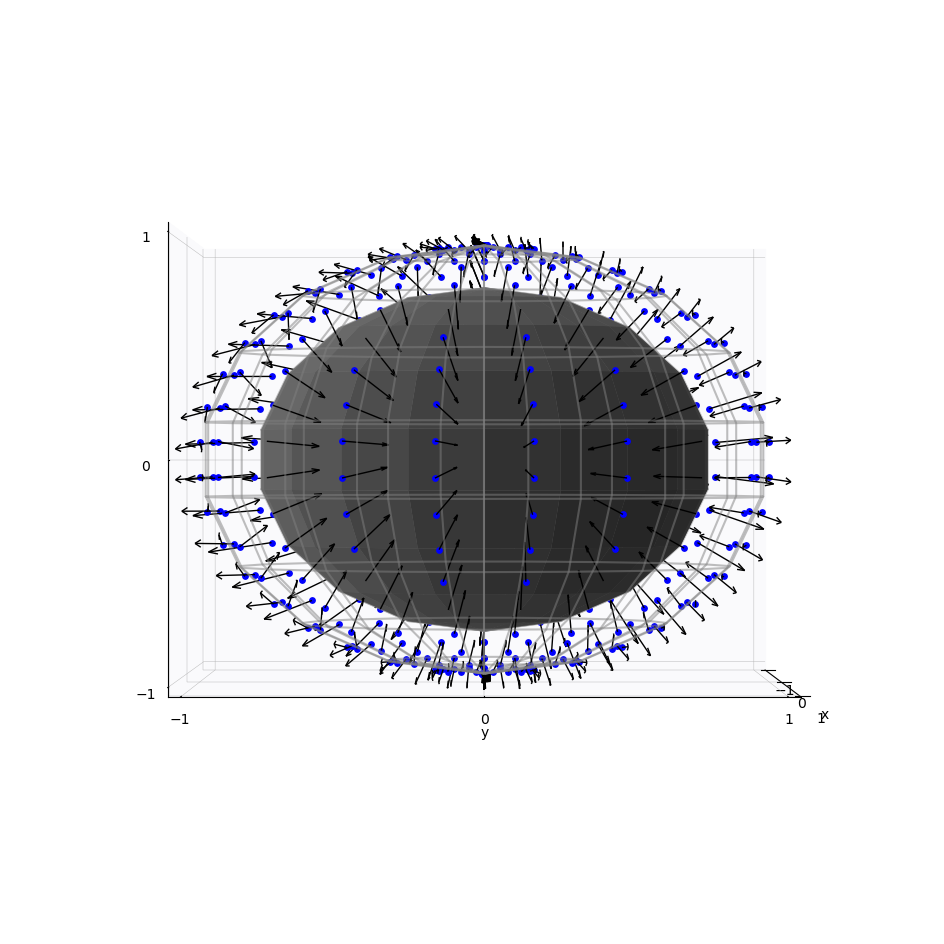

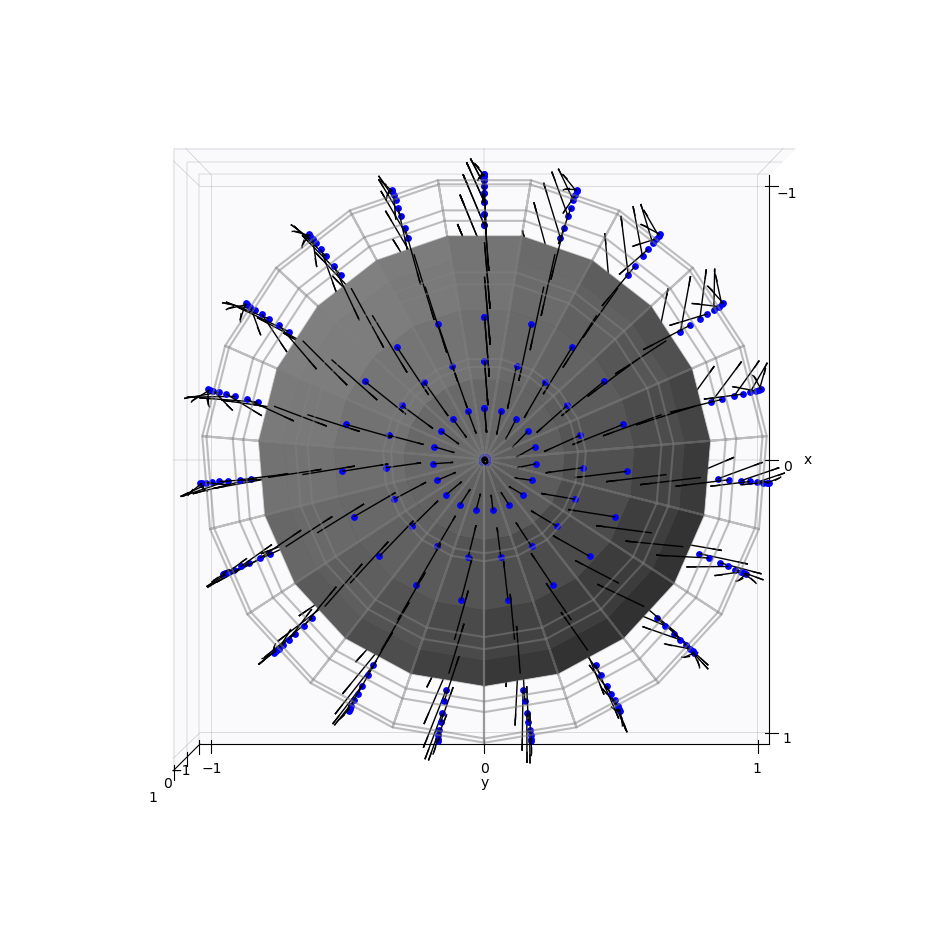

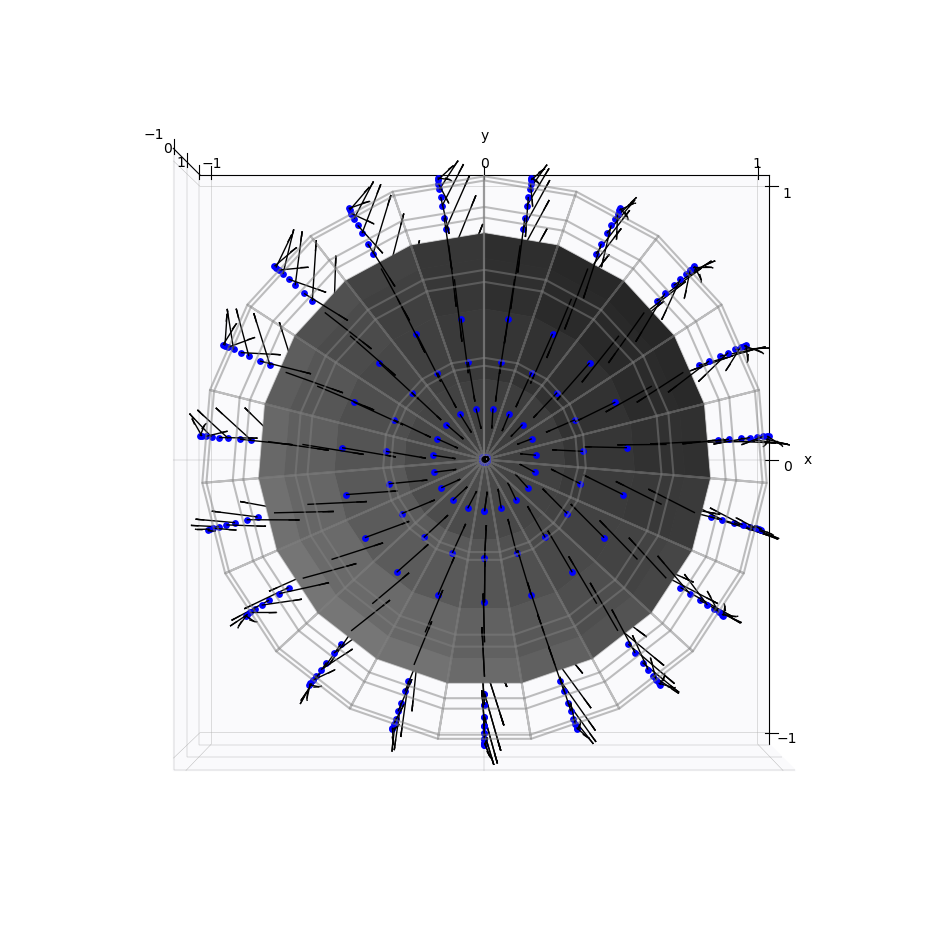

In [25]:
# %matplotlib inline
y = get_coords(jnp.array([1.,0.,0.]))
newfig()
M.plot(alpha=1.,scale=.8,rotate=(0,0))
plot_sphere_f(M,lambda Fx: to_TM(Fx,net.apply(params,jnp.hstack((M.F(y),Fx)))),pts=20)

y = get_coords(jnp.array([0.,0.,1.]))
newfig()
M.plot(alpha=1.,scale=.8,rotate=(90,0))
plot_sphere_f(M,lambda Fx: to_TM(Fx,net.apply(params,jnp.hstack((M.F(y),Fx)))),pts=20)

y = get_coords(jnp.array([0.,0.,-1.]))
newfig()
M.plot(alpha=1.,scale=.8,rotate=(-90,0))
plot_sphere_f(M,lambda Fx: to_TM(Fx,net.apply(params,jnp.hstack((M.F(y),Fx)))),pts=20)

# Score matching, general

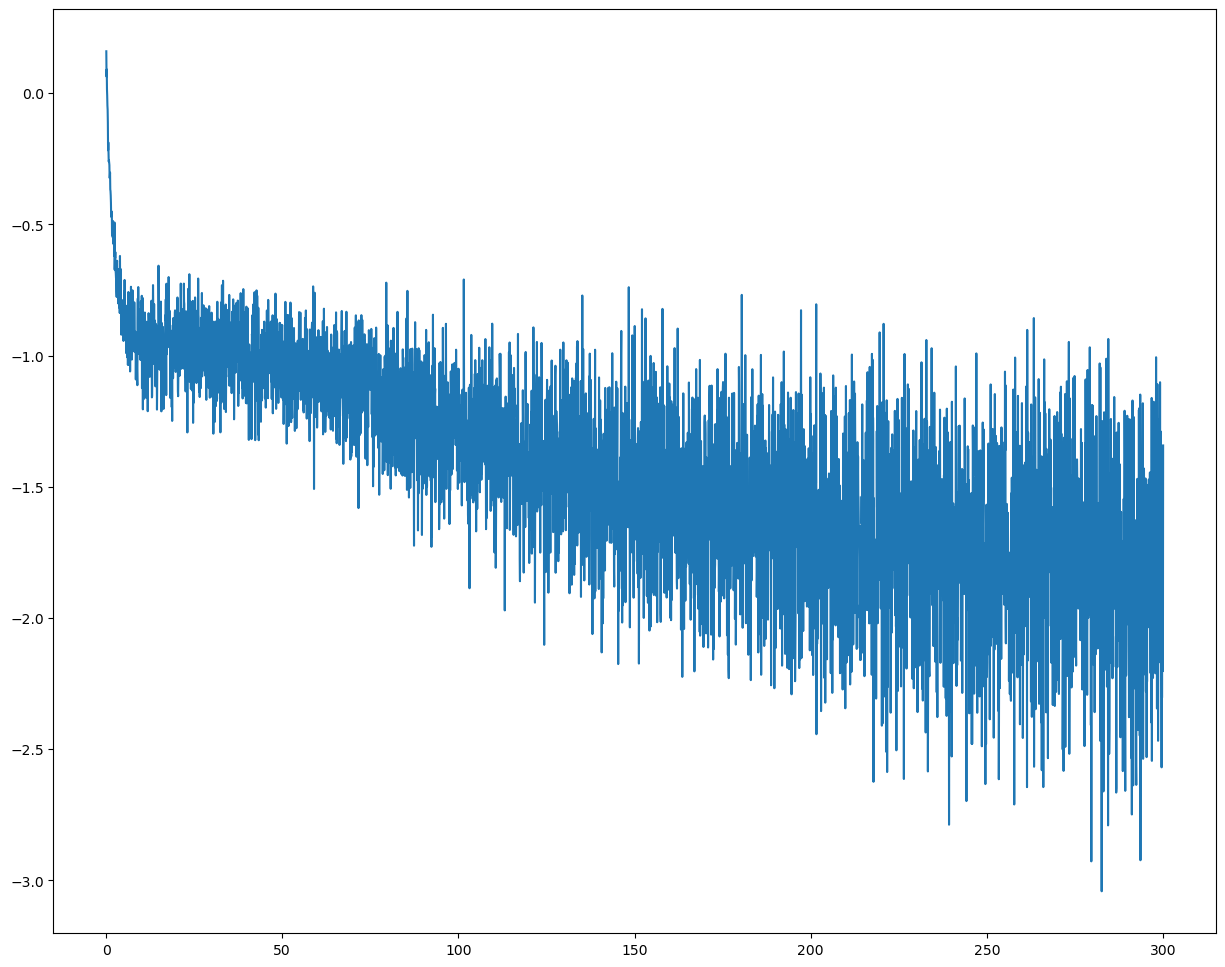

In [26]:
import haiku as hk
import optax
import jaxopt
import tensorflow as tf
import tensorflow_datasets as tfds

learning_rate = 0.01 # Learning rate for optimizer
epochs = 300 # Number of passes over the dataset
samples_per_x0 = 2**5
ts_per_batch = 32
repeats = 2**3
batch_size = samples_per_x0*ts_per_batch*repeats
samples_size = batch_size*2**4 # Total number of samples per epoch
print(samples_per_x0,ts_per_batch,repeats,batch_size,samples_size)

global x0s
x0s = tile(x,repeats)

def generator():
    while True:
        """Generates batches of samples."""
        N = samples_per_x0*repeats
        _dts = dts(T=1.)
        global x0s
        (ts,xss,chartss,*_) = product((jnp.repeat(x0s[0],samples_per_x0,axis=0),jnp.repeat(x0s[1],samples_per_x0,axis=0)),
                                      _dts,dWs(N*M.dim,_dts).reshape(-1,N,M.dim),jnp.repeat(1.,N))
        Fx0s = jax.vmap(lambda x,chart: M.F((x,chart)))(*x0s)
        x0s = (xss[-1,::samples_per_x0],chartss[-1,::samples_per_x0])
        inds = np.random.choice(range(_dts.shape[0]),ts_per_batch,replace=False)
#         inds = jnp.arange(0,ts.shape[0]+1,ts.shape[0]//ts_per_batch)[1:]-1
#         inds = jnp.array([-1,-1])
        ts = ts[inds]
        samples = xss[inds]
        charts = chartss[inds]
        yield jnp.hstack((jnp.tile(jnp.repeat(Fx0s,samples_per_x0,axis=0),(ts_per_batch,1)),
                         jax.vmap(lambda x,chart: M.F((x,chart)))(samples.reshape((-1,M.dim)),charts.reshape((-1,chartss.shape[-1]))),
                         jnp.repeat(ts,N).reshape((-1,1))
                        ))
        
ds = tf.data.Dataset.from_generator(generator,output_types=tf.float32,output_shapes=([batch_size,2*M.emb_dim+1]))

print(ds)
print(ds.element_spec)
ds = iter(tfds.as_numpy(ds))

def net_f(x):
    """Create model."""
    model = hk.Sequential([
        hk.Linear(100), jax.nn.tanh,
        hk.Linear(60), jax.nn.tanh,
        hk.Linear(M.emb_dim),
    ])
    y = model(x)
    return y


maxiter = epochs * samples_size // batch_size

# # initialize net and parameters
net = hk.without_apply_rng(hk.transform(net_f))
params = net.init(jax.random.PRNGKey(42), next(ds))

def loss_fun(params, data):
    """ compute loss."""
    s = net.apply(params,data)
    Fx0s = data[:,0:M.emb_dim]
    Fxts = data[:,M.emb_dim:2*M.emb_dim]
    ts = data[:,-1]
    (xts,chartts) = jax.vmap(get_coords)(Fxts)
    norm2s = jax.vmap(lambda s: jnp.sum(jnp.square(s)))(s)
    divs = jax.vmap(lambda Fx0,xt,chartt,t: M.div((xt,chartt),
                                                  lambda x: jnp.dot(M.invJF((M.F(x),x[1])),
                                                                    net.apply(params,jnp.hstack((Fx0,M.F(x),t)))))
                   )(Fx0s,xts,chartts,ts)
    return jnp.mean(norm2s+divs)

# Initialize solver.
losses = []
def pre_update(params,state,*ars,**kwargs):
    losses.append(state.value)
    if state.iter_num % 10 == 0:
#         print(f"[Step {state.iter_num}], epoch {state.iter_num//(samples_size//batch_size)}, training loss: {state.value:.3f}.")
        clear_output(wait=True); plt.plot(jnp.linspace(0,state.iter_num//(samples_size//batch_size),len(losses)),jnp.array(losses)); plt.show()
    return params,state

opt = optax.sgd(learning_rate)
solver = jaxopt.OptaxSolver(opt=opt,fun=loss_fun,maxiter=maxiter,pre_update=pre_update)

# run training loop
state = solver.init_state(params)
params, state = solver.run_iterator(
    init_params=params, iterator=ds)

# print loss graph
clear_output(wait=True); plt.plot(jnp.linspace(0,state.iter_num//(samples_size//batch_size),len(losses)),jnp.array(losses)); plt.show()

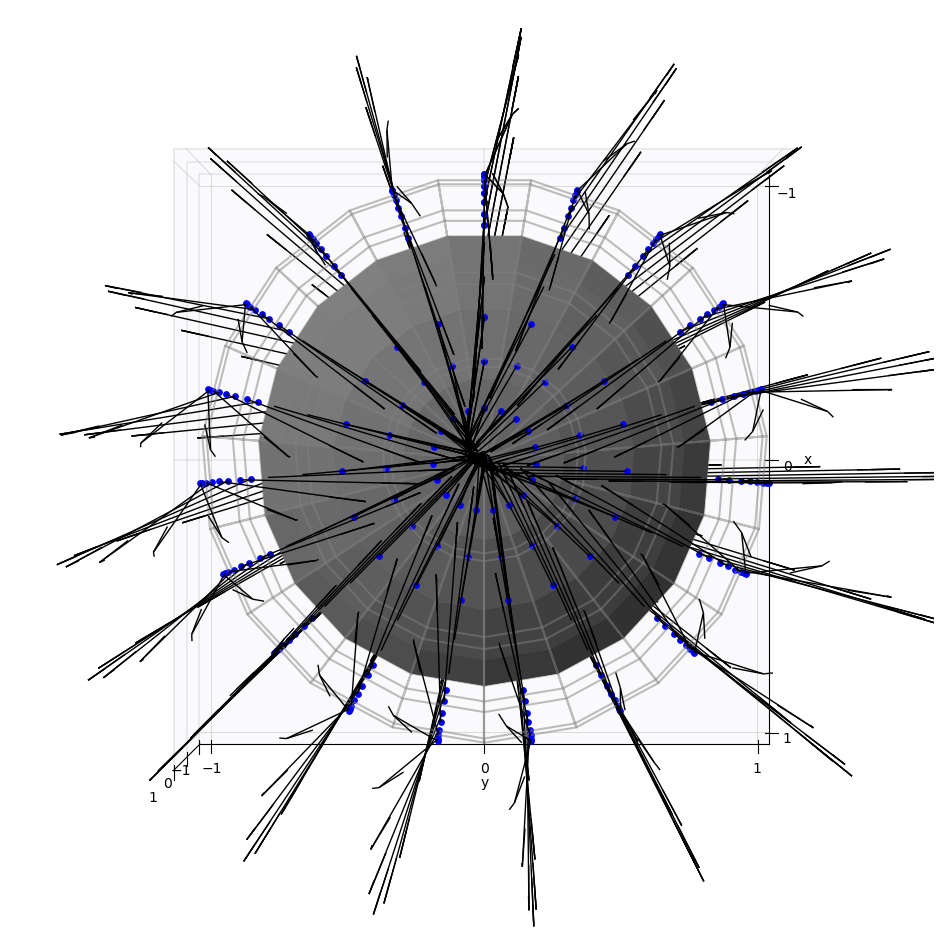

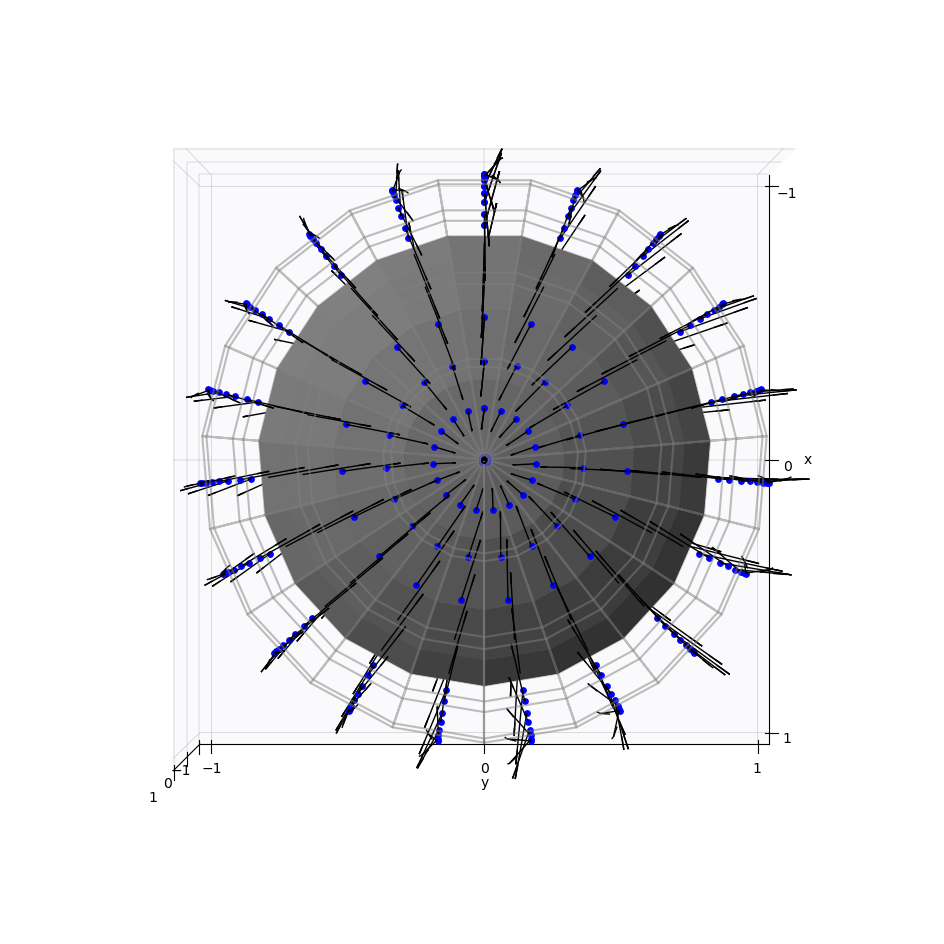

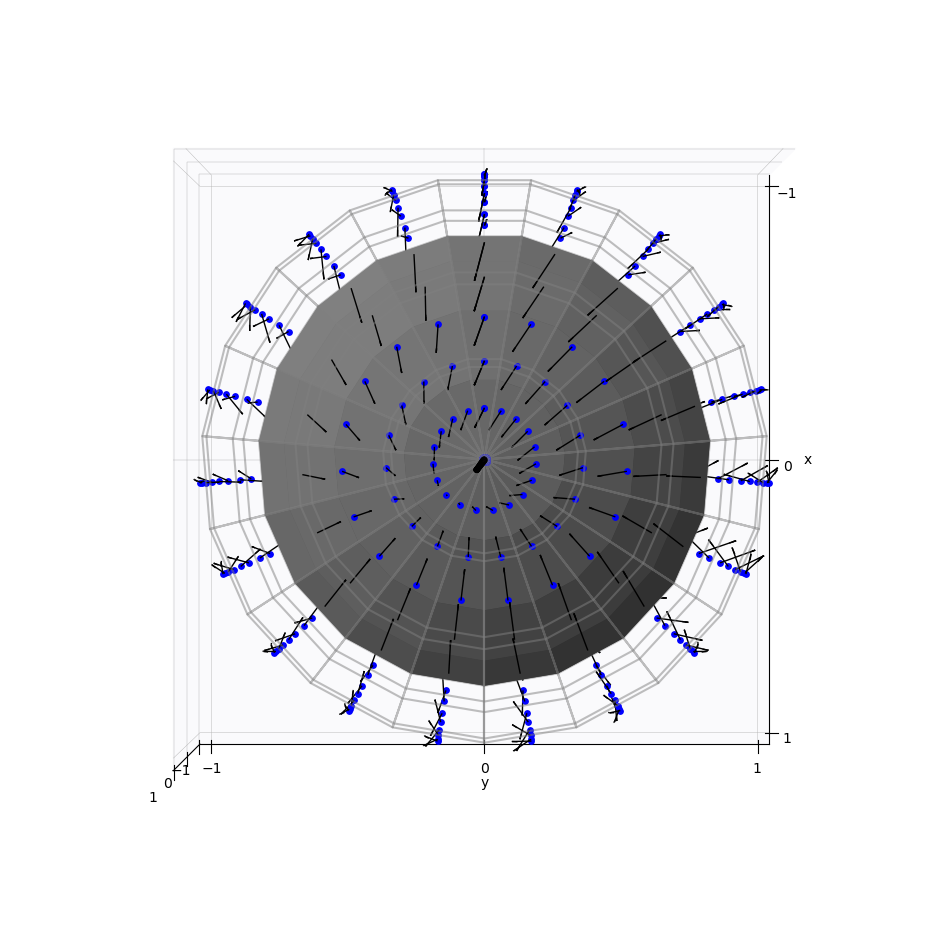

In [27]:
y = get_coords(jnp.array([0.,0.,1.]))
newfig()
M.plot(alpha=1.,scale=.8,rotate=(90,0))
plot_sphere_f(M,lambda Fx: to_TM(Fx,net.apply(params,jnp.hstack((M.F(y),Fx,.25)))),pts=20)

y = get_coords(jnp.array([0.,0.,1.]))
newfig()
M.plot(alpha=1.,scale=.8,rotate=(90,0))
plot_sphere_f(M,lambda Fx: to_TM(Fx,net.apply(params,jnp.hstack((M.F(y),Fx,.5)))),pts=20)

y = get_coords(jnp.array([0.,0.,1.]))
newfig()
M.plot(alpha=1.,scale=.8,rotate=(90,0))
plot_sphere_f(M,lambda Fx: to_TM(Fx,net.apply(params,jnp.hstack((M.F(y),Fx,1.)))),pts=20)

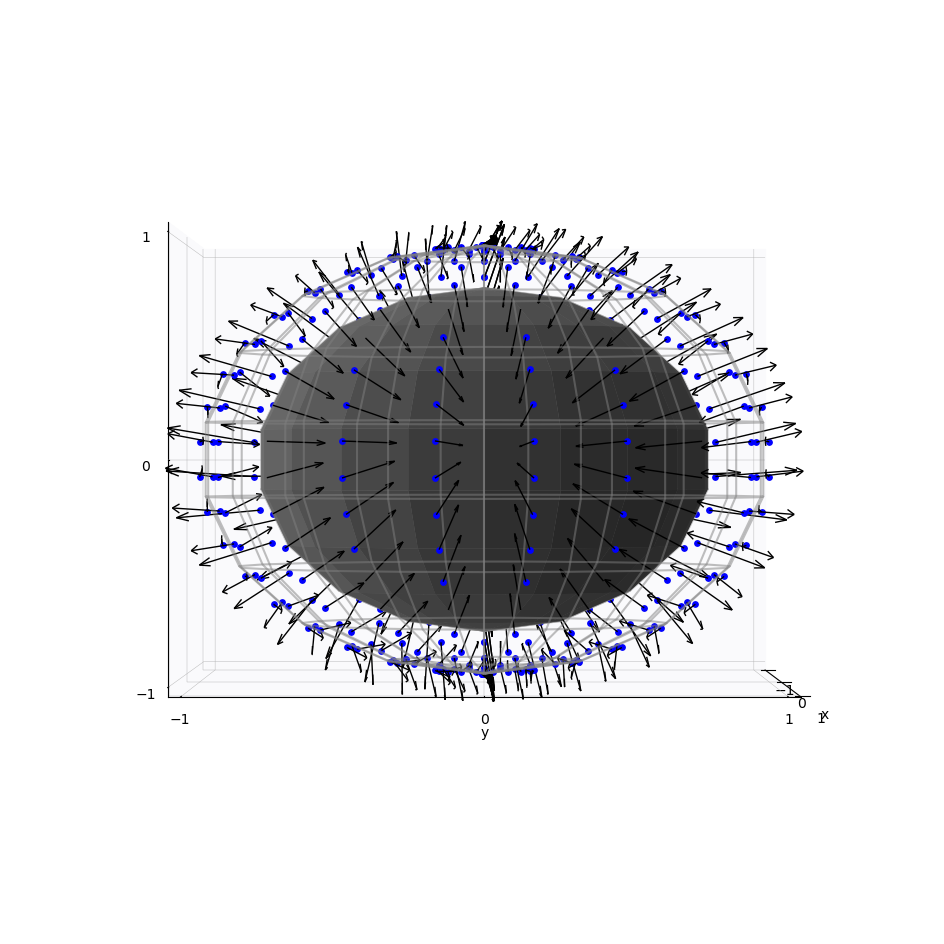

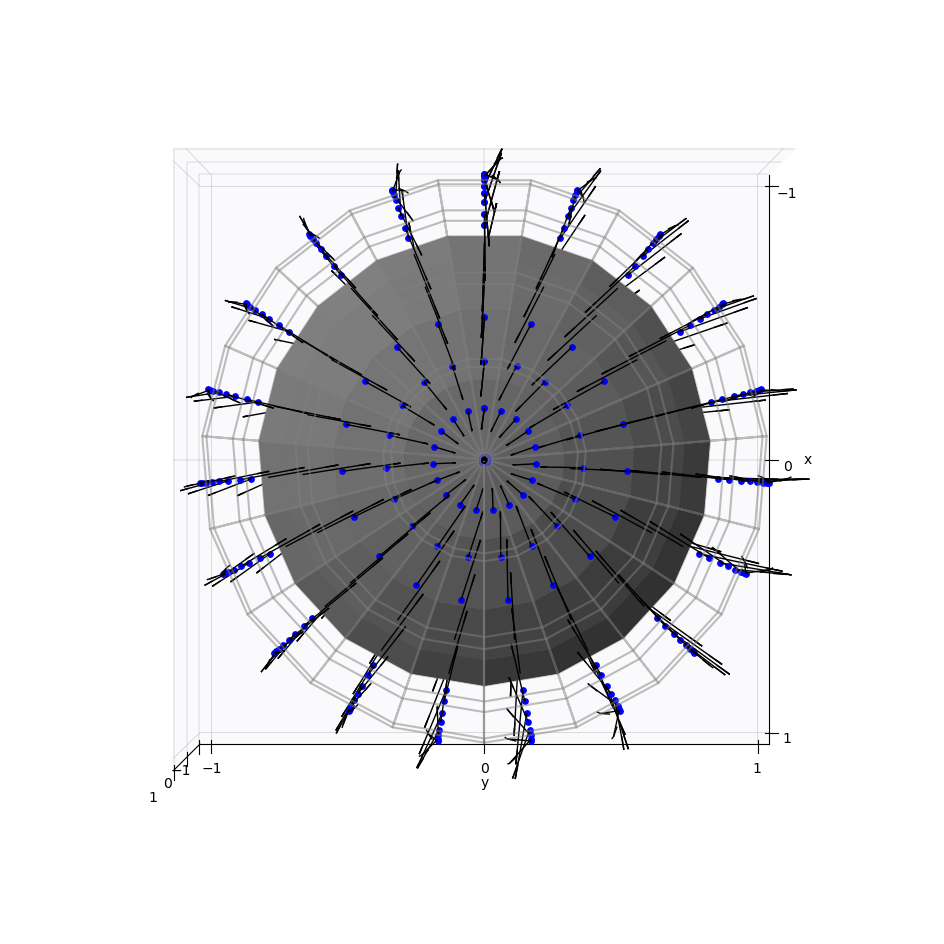

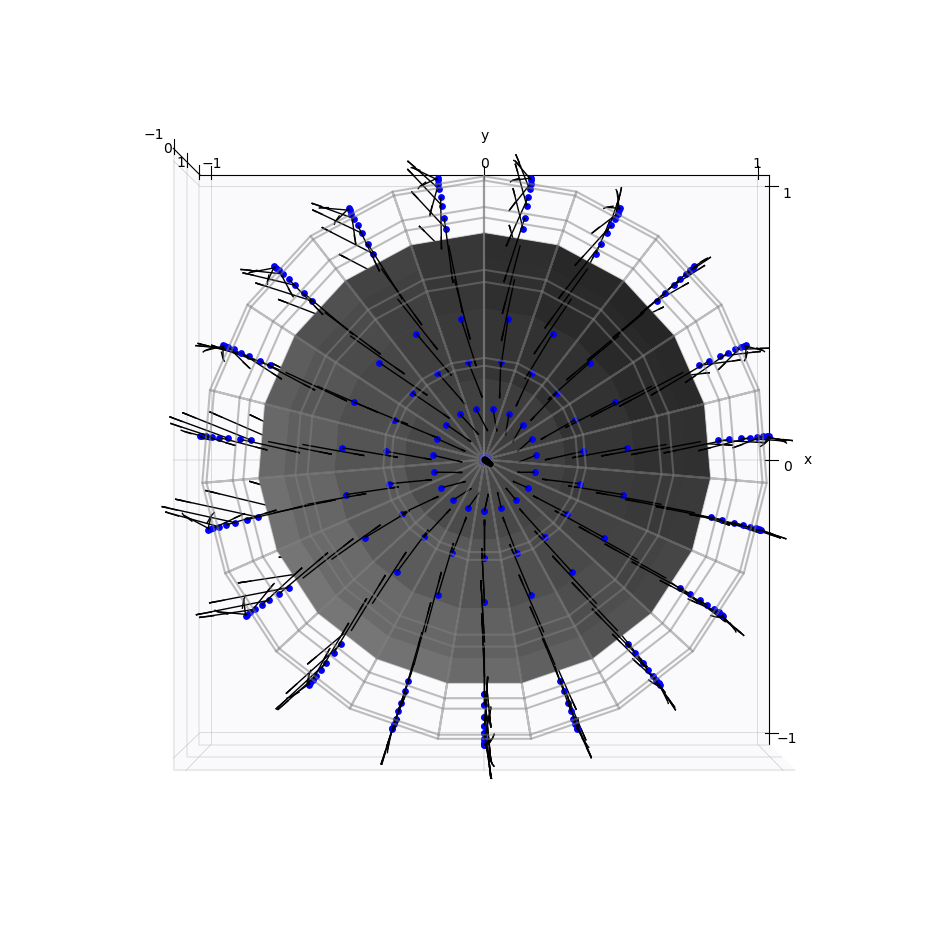

In [28]:
# %matplotlib inline
y = get_coords(jnp.array([1.,0.,0.]))
newfig()
M.plot(alpha=1.,scale=.8,rotate=(0,0))
plot_sphere_f(M,lambda Fx: to_TM(Fx,net.apply(params,jnp.hstack((M.F(y),Fx,.5)))),pts=20)

y = get_coords(jnp.array([0.,0.,1.]))
newfig()
M.plot(alpha=1.,scale=.8,rotate=(90,0))
plot_sphere_f(M,lambda Fx: to_TM(Fx,net.apply(params,jnp.hstack((M.F(y),Fx,.5)))),pts=20)

y = get_coords(jnp.array([0.,0.,-1.]))
newfig()
M.plot(alpha=1.,scale=.8,rotate=(-90,0))
plot_sphere_f(M,lambda Fx: to_TM(Fx,net.apply(params,jnp.hstack((M.F(y),Fx,.5)))),pts=20)